# 1. Importation des librairies et jeu de donnée

L'objectif de ce projet est de mettre au point un système de suggestion de tags pour le site de questions-réponses Stack Overflow, afin d'aider les nouveaux utilisateurs à choisir les tags pertinents pour leurs questions. L'algorithme de machine learning développé attribuera automatiquement plusieurs tags appropriés à une question donnée.


**Récupération des données**

Requête SQL : on souhaite séléctionner les 50000 individus sur la base de données (SELECT TOP 50000) disponible ici :
https://data.stackexchange.com/stackoverflow/query/edit/1729121#resultSets


Nous filtrons la récupération du jeu de données avec différents critères :
    
*   Ce sont des questions (PostTypeId = 1)
*   Les plus vues (ViewCount > 10) ;
*   Pouvant être considérées comme favorites par des internautes                (FavoriteCount >= 0, car si > 0, nous donne 137 individus seulement) ;
*   Considérées comme pertinentes par des internautes (Score > 0) ;
*   Ayant eu au moins une réponse (AnswerCount > 0)
*   Comprenant chacune 5 tags


 Requête finale :
```
SELECT TOP 50000 Title, Body, Tags, Id, Score, ViewCount, FavoriteCount, AnswerCount FROM Posts WHERE PostTypeId = 1 AND ViewCount > 0 AND FavoriteCount >= 0
AND Score > 0 AND AnswerCount > 0 AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) = 5
```



In [ ]:
# Python libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import wordnet
import nltk

from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path ="/content/drive/MyDrive/"
df1 = pd.read_csv(path + 'QueryResults.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df1.head()

,Title,Body,Tags,Id,Score,ViewCount,AnswerCount,CommentCount
0,Exclude Laravel-specific values from request,<p>I want to run <code>json_encode($request-&g...,<php><laravel><laravel-5><laravel-request><lar...,38664845,6,11470,2,0
1,"What is the difference between public, protect...","<p>In Java, are there clear rules on when to u...",<java><private><public><protected><access-modi...,215497,3641,2529955,30,12
2,Principal Component Analysis not working,<p>I'm trying to do principal component analys...,<python><numpy><machine-learning><scipy><sciki...,19410491,6,17711,2,5
3,How to load text of MS Word document in C# (.N...,<p>How do I load MS Word document (.doc and .d...,<c#><.net><ms-word><docx><doc>,215620,6,22525,7,0
4,What are the best uses of Logic Programming?,<p><em>By Logic Programming I mean the a sub-p...,<functional-programming><prolog><logic><logic-...,215742,34,19834,8,0


In [ ]:
df1.shape

(5000, 8)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         5000 non-null   object
 1   Body          5000 non-null   object
 2   Tags          5000 non-null   object
 3   Id            5000 non-null   int64 
 4   Score         5000 non-null   int64 
 5   ViewCount     5000 non-null   int64 
 6   AnswerCount   5000 non-null   int64 
 7   CommentCount  5000 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 312.6+ KB


In [ ]:
df1.duplicated().sum()

0

In [ ]:
df1.duplicated(subset ='Title').sum()

0

In [ ]:
df1.duplicated(subset ='Body').sum()

0

In [ ]:
df1.duplicated(subset ='Tags').sum()

14

In [ ]:
# Find the duplicated rows based on the 'Tags' column
duplicated_tags = df1[df1['Tags'].duplicated(keep = False)]

# Display the duplicated rows
duplicated_tags

,Title,Body,Tags,Id,Score,ViewCount,AnswerCount,CommentCount
249,How to fallback to a different value in 'WHERE...,<p>I have a case where i have to fetch records...,<mysql><sql><database><oracle><postgresql>,38715625,13,9099,7,2
598,How do you run a script on login in *nix?,<p>I know I once know how to do this but... ho...,<linux><bash><macos><unix><shell>,97137,73,162854,11,1
992,AJAX call and clean JSON but Syntax Error: mis...,<p>I am making a cross domain JSONP call using...,<javascript><jquery><ajax><json><jsonp>,19456146,42,56264,6,6
1146,"How to isolate everything inside of a contour,...","<p>I'm working on a project just for fun, and ...",<python><image><opencv><image-processing><comp...,59401389,7,3248,1,0
1175,How to tint UIBarButtonItem background color?,<p>I have a UIToolbar that contains 2 buttons....,<iphone><objective-c><cocoa-touch><interface-b...,3274473,9,38811,6,0
1225,Bootstrap-Select opens option under the div,<p>I have a fixed size div. suppose 50px. Insi...,<javascript><jquery><html><css><twitter-bootst...,22603864,9,12756,2,2
1504,"DateTime.Parse(""2012-09-30T23:00:00.0000000Z"")...",<p>I want to parse a string that represent a D...,<c#><asp.net><.net><datetime><utc>,10029099,69,51004,5,0
1580,Combine IS NULL and :value in Doctrine 2 DQL,<p>Since other (old) questions didn't get prop...,<php><symfony><doctrine-orm><doctrine><dql>,28405835,7,11289,2,0
2011,Symfony and Doctrine DQL query builder: how to...,<p>Using Symfony and Doctrine with the DQL que...,<php><symfony><doctrine-orm><doctrine><dql>,37326605,9,18080,2,2
2261,How to select the nth row in a SQL database ta...,<p>I'm interested in learning some (ideally) d...,<mysql><sql><database><oracle><postgresql>,16568,486,1031821,34,3


Ici nous voyons que il y a des doublons dans la colonne Tags, mais lorsque l'on analyse le contenu des documents Title & Body, nous voyons qu'ils sont différents. De plus, la colonne "Tags" sert généralement à classifier ou à catégoriser les questions en fonction de leurs sujets ou domaines. Il est donc tout à fait possible d'avoir des questions avec des contenus différents mais qui sont liées à des sujets similaires et donc qui partagent les mêmes tags.

In [ ]:
df1.describe()

,Id,Score,ViewCount,AnswerCount,CommentCount
count,5.000000e+03,5000.000000,5.000000e+03,5000.000000,5000.00000
mean,2.033161e+07,49.732000,4.080853e+04,4.326000,2.14220
std,2.054433e+07,275.686978,1.673973e+05,4.775299,3.20837
min,4.000000e+00,6.000000,5.800000e+01,1.000000,0.00000
25%,2.823474e+06,7.000000,3.520000e+03,2.000000,0.00000
50%,1.800776e+07,11.000000,9.561000e+03,3.000000,1.00000
75%,3.868972e+07,22.000000,2.546625e+04,5.000000,3.00000
max,7.662448e+07,7480.000000,5.812902e+06,66.000000,40.00000


# 2.Nettoyage du jeu de donnée

In [ ]:
# Séléction des colonnes d'intérets
df = df1[['Title', 'Body', 'Tags']]
df.head(5)


,Title,Body,Tags
0,Exclude Laravel-specific values from request,<p>I want to run <code>json_encode($request-&g...,<php><laravel><laravel-5><laravel-request><lar...
1,"What is the difference between public, protect...","<p>In Java, are there clear rules on when to u...",<java><private><public><protected><access-modi...
2,Principal Component Analysis not working,<p>I'm trying to do principal component analys...,<python><numpy><machine-learning><scipy><sciki...
3,How to load text of MS Word document in C# (.N...,<p>How do I load MS Word document (.doc and .d...,<c#><.net><ms-word><docx><doc>
4,What are the best uses of Logic Programming?,<p><em>By Logic Programming I mean the a sub-p...,<functional-programming><prolog><logic><logic-...


In [ ]:
# Installation de langdetect pour identifier les langues de notre df
!pip install langdetect

In [ ]:
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

for index, row in df.iterrows():
    text = row['Body']
    try:
        lang = detect(text)
        df.loc[index, 'lang'] = lang
    except LangDetectException as e:
        df.loc[index, 'lang'] = 'unknown'

lang_counts = df['lang'].value_counts()


<ipython-input-99-ea506184f1a0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'lang'] = lang


In [ ]:
lang_counts

en         4991
nl            3
da            2
fr            2
it            1
unknown       1
Name: lang, dtype: int64

In [ ]:
# Filtrage du df sur la langue la plus utilisée
df = df[df['lang']=='en']
df = df[['Body', 'Title','Tags']]

In [ ]:
df.head(20)

,Body,Title,Tags
0,<p>I want to run <code>json_encode($request-&g...,Exclude Laravel-specific values from request,<php><laravel><laravel-5><laravel-request><lar...
1,"<p>In Java, are there clear rules on when to u...","What is the difference between public, protect...",<java><private><public><protected><access-modi...
2,<p>I'm trying to do principal component analys...,Principal Component Analysis not working,<python><numpy><machine-learning><scipy><sciki...
3,<p>How do I load MS Word document (.doc and .d...,How to load text of MS Word document in C# (.N...,<c#><.net><ms-word><docx><doc>
4,<p><em>By Logic Programming I mean the a sub-p...,What are the best uses of Logic Programming?,<functional-programming><prolog><logic><logic-...
5,<p>I'm trying to batch put a number of items t...,AppSync BatchPutItem not saving items,<amazon-web-services><amazon-dynamodb><graphql...
6,<p>How hard would it be to use GCC instead of ...,GCC with Visual Studio?,<visual-studio><visual-studio-2008><visual-c++...
7,<p>I am working on a desktop application in Py...,How do I coherently organize modules for a PyG...,<python><gtk><module><pygtk><organization>
8,<p>I am trying to implement signature verifica...,PKCS#7 Signature Verification,<c><security><openssl><digital-signature><pkcs#7>
9,<p>What are the best practices and rules-of-th...,How do you maintain development code and produ...,<deployment><version-control><continuous-integ...


Nous voyons dans la colonne de Tags la présence des balises "<>" elles-mêmes ne doivent pas être incluses dans les tags lorsqu'ils sont utilisés pour suggérer des mots-clés ou des catégories. Nous allons traiter cela via Regex

In [ ]:
# Nous supprimons les '<>' par ',' grâce à la manipulation Regex (https://regex101.com/), puis créons une nouvelle liste où nous supprimons les commas en trop.

import re

df['Tags'] = df['Tags'].apply(lambda x: re.sub(r'<|>', ',', x))
df['Tags'] = df['Tags'].apply(lambda x: [tag for tag in x.split(',') if tag.strip()])

In [ ]:
df.sample(20)

,Body,Title,Tags
1999,<p><strong>Input:</strong></p>\n\n<pre><code>p...,How to find the nearest neighbors for latitude...,"[python, geolocation, scipy, nearest-neighbor,..."
4980,<p>I've been looking for a way to download an ...,"Python/Django download Image from URL, modify,...","[python, django, file, python-imaging-library,..."
2943,<p>I am creating an App with AngularJS and Boo...,Best way to represent a Grid or Table in Angul...,"[angularjs, twitter-bootstrap-3, ng-grid, angu..."
2783,<p>I have a .Net webserivce that accepts <code...,How to Deserialize XMLDocument to object in C#?,"[c#, .net, xml, web-services, xml-deserializat..."
1376,"<p>For my project, which is a potentially big ...",CQRS and primary key: guid or not?,"[c#, performance, key, guid, cqrs]"
2302,"<p>I have read <a href=""http://highscalability...",What is the Reason large sites don't use MySQL...,"[asp.net, sql, mysql, sql-server, scalability]"
962,<p>I am trying to use IPython notebook on MacO...,How to make IPython notebook matplotlib plot i...,"[python, matplotlib, jupyter-notebook, ipython..."
4408,<p>I'm developing an iOS 7 app that has script...,Is there any way stopping or pausing the execu...,"[javascript, ios, cocoa, webkit, javascriptcore]"
798,<p>I'm doing some experiments with Microsoft D...,Slow SoapHttpClientProtocol constructor,"[c#, .net, performance, xml-serialization, soa..."
472,<p>Consider the following macros:</p>\n\n<pre>...,Weird Macros (TASM),"[assembly, macros, interrupt, tasm, dosbox]"


Nous voyons dans la colonne Body  les questions génèralement sauvegardées  avec les balises HTML, il contient également du code. Nous allons ainsi supprimer ceux deux bruits via BeautifulSoup est une bibliothèque Python largement utilisée pour l'analyse et le web scraping (extraction de données à partir de sites web). Elle facilite le parcours, l'extraction et la manipulation de données à partir de fichiers HTML et XML.

In [ ]:
def remove_code(x):
    """Function based on the Beautifulsoup library intended to replace
    the content of all the <code> </code> in the body of a text specified as a parameter.
    """
    soup = BeautifulSoup(x,"lxml")
    code_to_remove = soup.findAll("code")
    for code in code_to_remove:
        code.replace_with(" ")
    return str(soup)
#deleting code and html in the body of dataframe
df['Body'] = df['Body'].apply(lambda text: remove_code(text))
df.Body = [BeautifulSoup(text,"lxml").get_text() for text in df.Body]

In [ ]:
df.sample(20)

,Body,Title,Tags
4472,I use one region with 2 views. I have a that...,What is the difference between region activati...,"[c#, wpf, mvvm, prism, region]"
2599,"attribute is nice and handy MS invention, an...",How to make Authorize attribute return custom ...,"[c#, .net, asp.net-mvc, security, authorization]"
1121,I'm getting the following error trying redeplo...,AccessControlException when trying to redeploy...,"[tomcat, netbeans, tomcat6, netbeans6.8, acces..."
3265,"As I read in books and in the web, in C++ we c...",Why we use reference return in assignment oper...,"[c++, operators, operator-overloading, return-..."
3877,I noticed that the children of PersistentUser ...,Google App Engine - DELETE JPQL Query and Casc...,"[java, google-app-engine, jpa, google-cloud-da..."
3569,"Ok, so i have this template class, which is ki...",Template class type-specific functions,"[c++, class, templates, template-function, tem..."
3744,I have ceated several django apps and stuffs f...,model not showing up in django admin,"[python, django, django-admin, django-settings..."
2936,What do you think is the advantages/disadvanta...,Java REST implementation: Jersey vs CXF,"[java, web-services, rest, cxf, jersey]"
4240,I am upgrading an Asp.Net Website project to ....,Error in publishing project with MSBuild after...,"[c#, asp.net, .net, msbuild, .net-4.8]"
4101,I've got a List collection and I want to itera...,Lock vs. ToArray for thread safe foreach acces...,"[c#, multithreading, foreach, locking, toarray]"


In [ ]:
def clean_text(text):
    if isinstance(text, list):
        text = ' '.join(text)  # Convertir la liste en une chaîne de caractères
    text = text.lower()
    text = re.sub("\'\w+", ' ', text)
    text = text.encode("ascii", "ignore").decode()
    text = re.sub('[^\\w\\s#\\s++]', ' ', text)
    text = re.sub(r'\w*\d+\w*', ' ', text)
    text = re.sub('\s+', ' ', text)
    return text

df['Body'] = df['Body'].apply(lambda text: clean_text(text))
df['Title'] = df['Title'].apply(lambda text: clean_text(text))

# Traitement spécifique pour la colonne 'Tags' sans l'appel à 'lower'
df['Tags'] = df['Tags'].apply(lambda text: ' '.join(text) if isinstance(text, list) else text)

df['Tags'] = df['Tags'].apply(lambda text: clean_text(text))

In [ ]:
df.head()

,Body,Title,Tags
0,i want to run after a form is submitted howeve...,exclude laravel specific values from request,php laravel laravel laravel request laravel form
1,in java are there clear rules on when to use e...,what is the difference between public protecte...,java private public protected access modifiers
2,i trying to do principal component analysis on...,principal component analysis not working,python numpy machine learning scipy scikit learn
3,how do i load ms word document doc and docx to...,how to load text of ms word document in c# net,c# net ms word docx doc
4,by logic programming i mean the a sub paradigm...,what are the best uses of logic programming,functional programming prolog logic logic prog...


In [ ]:
def words_tokenize(text):
  text = text.split()
  return text

df['Body'] = df.Body.apply(lambda text: words_tokenize(text))
df['Title'] = df.Title.apply(lambda text: words_tokenize(text))
df['Tags'] = df.Tags.apply(lambda text: words_tokenize(text))

In [ ]:
df.head(20)

,Body,Title,Tags
0,"[i, want, to, run, after, a, form, is, submitt...","[exclude, laravel, specific, values, from, req...","[php, laravel, laravel, laravel, request, lara..."
1,"[in, java, are, there, clear, rules, on, when,...","[what, is, the, difference, between, public, p...","[java, private, public, protected, access, mod..."
2,"[i, trying, to, do, principal, component, anal...","[principal, component, analysis, not, working]","[python, numpy, machine, learning, scipy, scik..."
3,"[how, do, i, load, ms, word, document, doc, an...","[how, to, load, text, of, ms, word, document, ...","[c#, net, ms, word, docx, doc]"
4,"[by, logic, programming, i, mean, the, a, sub,...","[what, are, the, best, uses, of, logic, progra...","[functional, programming, prolog, logic, logic..."
5,"[i, trying, to, batch, put, a, number, of, ite...","[appsync, batchputitem, not, saving, items]","[amazon, web, services, amazon, dynamodb, grap..."
6,"[how, hard, would, it, be, to, use, gcc, inste...","[gcc, with, visual, studio]","[visual, studio, visual, studio, visual, c++, ..."
7,"[i, am, working, on, a, desktop, application, ...","[how, do, i, coherently, organize, modules, fo...","[python, gtk, module, pygtk, organization]"
8,"[i, am, trying, to, implement, signature, veri...","[pkcs#, signature, verification]","[c, security, openssl, digital, signature, pkcs#]"
9,"[what, are, the, best, practices, and, rules, ...","[how, do, you, maintain, development, code, an...","[deployment, version, control, continuous, int..."


Les stopwords, dans le contexte du traitement du langage naturel (NLP), sont des mots très courants et fréquemment utilisés dans une langue donnée. Ils incluent des mots tels que "le", "de", "et", "à", "est", "sont", etc. Ces mots n'apportent généralement pas beaucoup de sens ou d'informations spécifiques lors de l'analyse de texte ou de la recherche d'informations.
L'utilisation des stopwords dans le traitement du langage naturel vise principalement à réduire le bruit et à améliorer les performances des tâches de NLP.

In [ ]:
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
df['Body_filtered'] = df['Body'].apply(lambda x: ' '.join([word for word in x if word.lower() not in stop_words]))
df['Title_filtered'] = df['Title'].apply(lambda x: ' '.join([word.lower() for word in x if word.lower() not in stop_words]))

In [ ]:
df

,Body,Title,Tags,Body_filtered,Title_filtered
0,"[i, want, to, run, after, a, form, is, submitt...","[exclude, laravel, specific, values, from, req...","[php, laravel, laravel, laravel, request, lara...",want run form submitted however returned array...,exclude laravel specific values request
1,"[in, java, are, there, clear, rules, on, when,...","[what, is, the, difference, between, public, p...","[java, private, public, protected, access, mod...",java clear rules use access modifiers namely d...,difference public protected package private pr...
2,"[i, trying, to, do, principal, component, anal...","[principal, component, analysis, not, working]","[python, numpy, machine, learning, scipy, scik...",trying principal component analysis datasets c...,principal component analysis working
3,"[how, do, i, load, ms, word, document, doc, an...","[how, to, load, text, of, ms, word, document, ...","[c#, net, ms, word, docx, doc]",load ms word document doc docx memory variable...,load text ms word document c# net
4,"[by, logic, programming, i, mean, the, a, sub,...","[what, are, the, best, uses, of, logic, progra...","[functional, programming, prolog, logic, logic...",logic programming mean sub paradigm declarativ...,best uses logic programming
...,...,...,...,...,...
4995,"[currently, we, are, working, with, github, an...","[migrate, or, export, github, wiki, to, gitlab]","[git, github, export, wiki, gitlab]",currently working github actually quiet happy ...,migrate export github wiki gitlab
4996,"[i, interested, in, experimenting, with, embed...","[how, should, i, embed, python, in, a, c++, bu...","[python, delphi, embed, c++builder, c++builder]",interested experimenting embedding python appl...,embed python c++ builder delphi application
4997,"[my, environment, in, local, git, connecting, ...","[how, delete, a, local, branch, after, merging...","[git, bitbucket, git, branch, pull, request, g...",environment local git connecting bitbucket sou...,delete local branch merging pull request git f...
4998,"[i, am, currently, using, moq, to, help, with,...","[unit, testing, throwifcancellationrequested, ...","[c#, unit, testing, mocking, moq, mstest]",currently using moq help unit testing however ...,unit testing throwifcancellationrequested called


In [ ]:
df = df.drop(columns=['Body', 'Title'])
df = df.rename(columns={'Body_filtered': 'Body', 'Title_filtered': 'Title'})

In [ ]:
df['Body'] = df.Body.apply(lambda text: words_tokenize(text))
df['Title'] = df.Title.apply(lambda text: words_tokenize(text))

In [ ]:
df.head(20)

,Tags,Body,Title
0,"[php, laravel, laravel, laravel, request, lara...","[want, run, form, submitted, however, returned...","[exclude, laravel, specific, values, request]"
1,"[java, private, public, protected, access, mod...","[java, clear, rules, use, access, modifiers, n...","[difference, public, protected, package, priva..."
2,"[python, numpy, machine, learning, scipy, scik...","[trying, principal, component, analysis, datas...","[principal, component, analysis, working]"
3,"[c#, net, ms, word, docx, doc]","[load, ms, word, document, doc, docx, memory, ...","[load, text, ms, word, document, c#, net]"
4,"[functional, programming, prolog, logic, logic...","[logic, programming, mean, sub, paradigm, decl...","[best, uses, logic, programming]"
5,"[amazon, web, services, amazon, dynamodb, grap...","[trying, batch, put, number, items, dynamodb, ...","[appsync, batchputitem, saving, items]"
6,"[visual, studio, visual, studio, visual, c++, ...","[hard, would, use, gcc, instead, vc++, within,...","[gcc, visual, studio]"
7,"[python, gtk, module, pygtk, organization]","[working, desktop, application, pygtk, seem, b...","[coherently, organize, modules, pygtk, desktop..."
8,"[c, security, openssl, digital, signature, pkcs#]","[trying, implement, signature, verification, p...","[pkcs#, signature, verification]"
9,"[deployment, version, control, continuous, int...","[best, practices, rules, thumb, follow, mainta...","[maintain, development, code, production, code]"


La lemmatisation est un processus linguistique qui consiste à réduire un mot à sa forme de base ou sa racine, appelée "lemme". Le lemme est généralement le dictionnaire ou la forme canonique d'un mot, qui représente le sens de ce mot de manière générale. La lemmatisation est utile dans le traitement du langage naturel (NLP) car elle permet de regrouper les différentes formes d'un mot en une seule, ce qui facilite l'analyse et la comparaison des textes. Cela aide également à réduire la dimensionnalité des données et à améliorer la performance des modèles de traitement du langage naturel. Nous utilisons ici le "Wordnet Lemmatizer" avec les parties du discours (POS) appropriées fournies par la fonction "nltk.pos_tag".

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
  # 1. Lemmatizer
lemmatizer = WordNetLemmatizer()
def lem_word(text):
  # 2. Lemmatize with the appropriate POS tag
    return [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text]

df['Body'] = df.Body.apply(lem_word)
df['Title'] = df.Title.apply(lem_word)
df['Tags'] = df.Tags.apply(lem_word)



In [ ]:
df.head(20)

,Tags,Body,Title
0,"[php, laravel, laravel, laravel, request, lara...","[want, run, form, submit, however, return, arr...","[exclude, laravel, specific, value, request]"
1,"[java, private, public, protect, access, modif...","[java, clear, rule, use, access, modifier, nam...","[difference, public, protect, package, private..."
2,"[python, numpy, machine, learn, scipy, scikit,...","[try, principal, component, analysis, datasets...","[principal, component, analysis, work]"
3,"[c#, net, m, word, docx, doc]","[load, m, word, document, doc, docx, memory, v...","[load, text, m, word, document, c#, net]"
4,"[functional, program, prolog, logic, logic, pr...","[logic, program, mean, sub, paradigm, declarat...","[best, us, logic, program]"
5,"[amazon, web, service, amazon, dynamodb, graph...","[try, batch, put, number, item, dynamodb, use,...","[appsync, batchputitem, save, item]"
6,"[visual, studio, visual, studio, visual, c++, ...","[hard, would, use, gcc, instead, vc++, within,...","[gcc, visual, studio]"
7,"[python, gtk, module, pygtk, organization]","[work, desktop, application, pygtk, seem, bump...","[coherently, organize, module, pygtk, desktop,..."
8,"[c, security, openssl, digital, signature, pkcs#]","[try, implement, signature, verification, pdfs...","[pkcs#, signature, verification]"
9,"[deployment, version, control, continuous, int...","[best, practice, rule, thumb, follow, maintain...","[maintain, development, code, production, code]"


In [ ]:
def plot_info(dataframe, column, top_n=50):
    # Flatten the list of tags or words
    all_items = dataframe[column].explode()

    # Create a DataFrame with the frequency of each tag or word
    df_freq = all_items.value_counts().reset_index()
    df_freq.columns = [column, 'Frequency']

    # Sort the DataFrame in descending order based on the Frequency column
    df_freq.sort_values("Frequency", ascending=False, inplace=True)

    # Print the total number of unique tags or words
    print("The dataset contains {} unique {} in column '{}'.".format(df_freq.shape[0], column, column))

    # Print the number of unique tags or words used once only
    unique = df_freq[df_freq['Frequency'] == 1]
    print(f"The dataset contains {unique.shape[0]} unique {column} used once only in column '{column}'.")

    # Plot the countplot of the top tags or words
    plt.figure(figsize=(20, 6))
    sns.barplot(data=df_freq.head(top_n), x=column, y='Frequency')
    plt.xticks(rotation=45)
    plt.title(f"Top {top_n} {column} in column '{column}'", fontsize=18)
    plt.show()

    # Create a word cloud of the top tags or words
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(dict(zip(df_freq[column], df_freq['Frequency'])))
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud of Top {top_n} {column} in column '{column}'", fontsize=18)
    plt.show()


The dataset contains 4146 unique Tags in column 'Tags'.
The dataset contains 1978 unique Tags used once only in column 'Tags'.


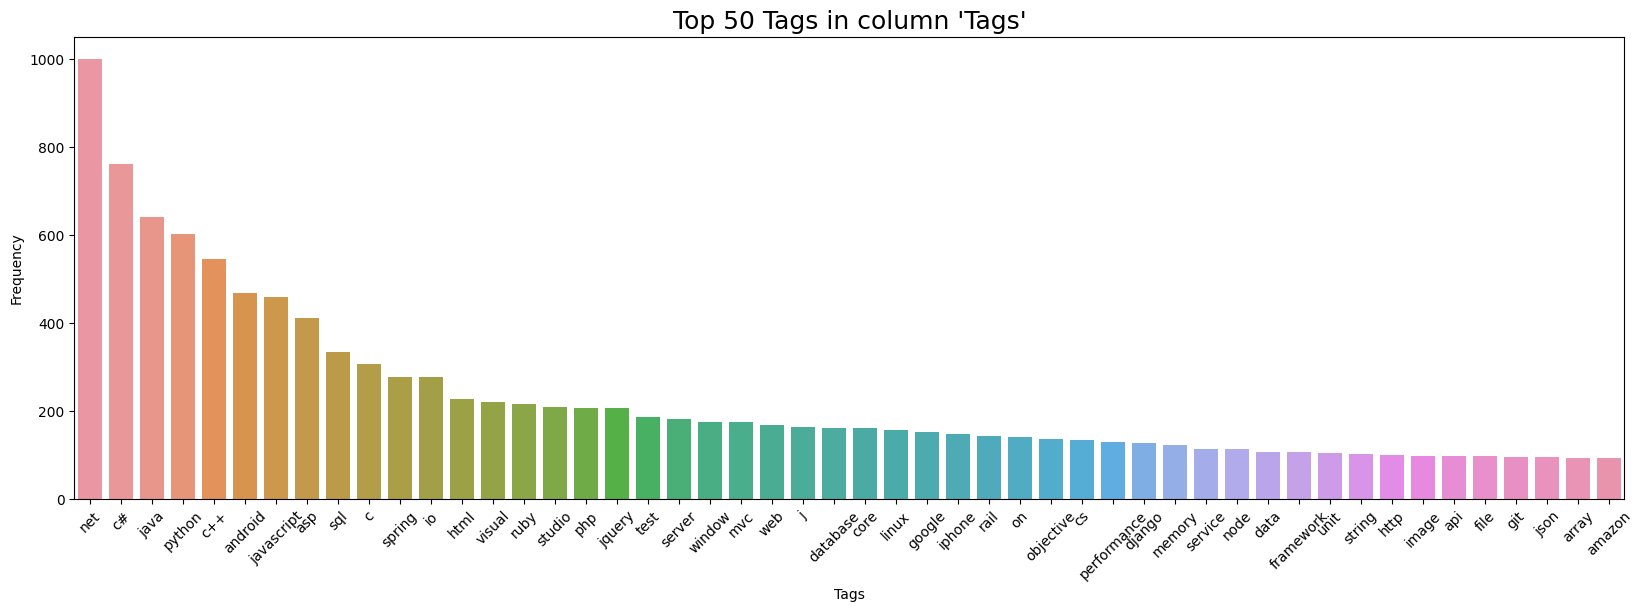

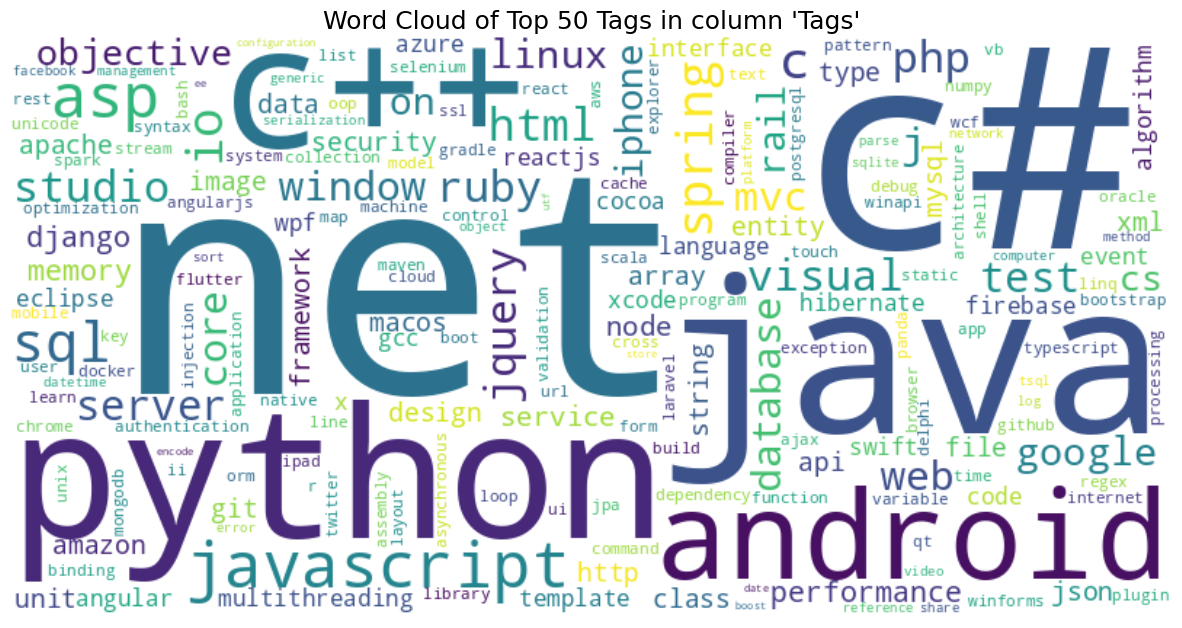

In [ ]:
plot_info(df, 'Tags')

Ici nous voyons que les mots les plus communs dans le corpus Tags sont liées au langage informatique.

De plus nous voyons que nous avons 1977 tokens uniques, or si un token est présent qu'une seule fois il y a de grande chance qu'il soit éleminé lors de la réduction de dimentionnalité soit qu'il ne puisse pas être utilisé comme dimension. Dans l'optique de Machine Learning nous souhaitons accélerer nos calculs nous avons tout intérêt à supprimer les tokens dont la fréquence est faible.


The dataset contains 15481 unique Body in column 'Body'.
The dataset contains 7109 unique Body used once only in column 'Body'.


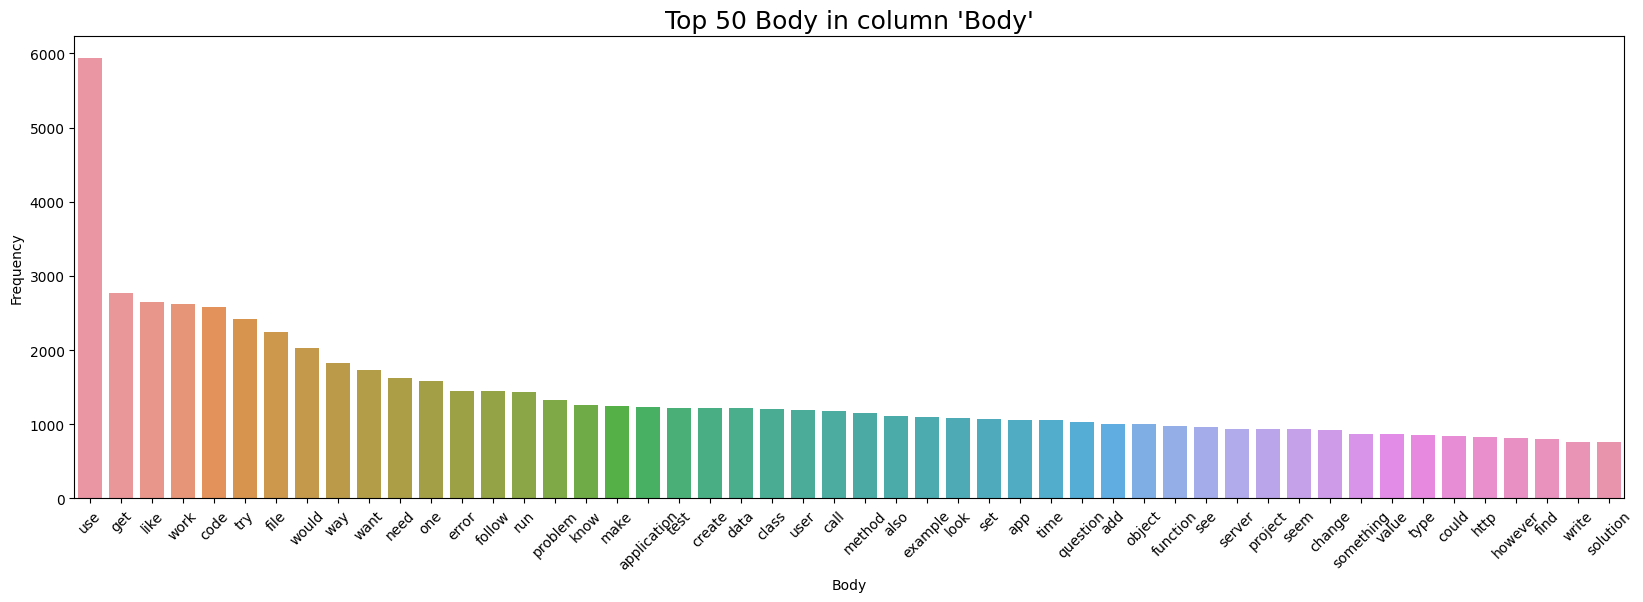

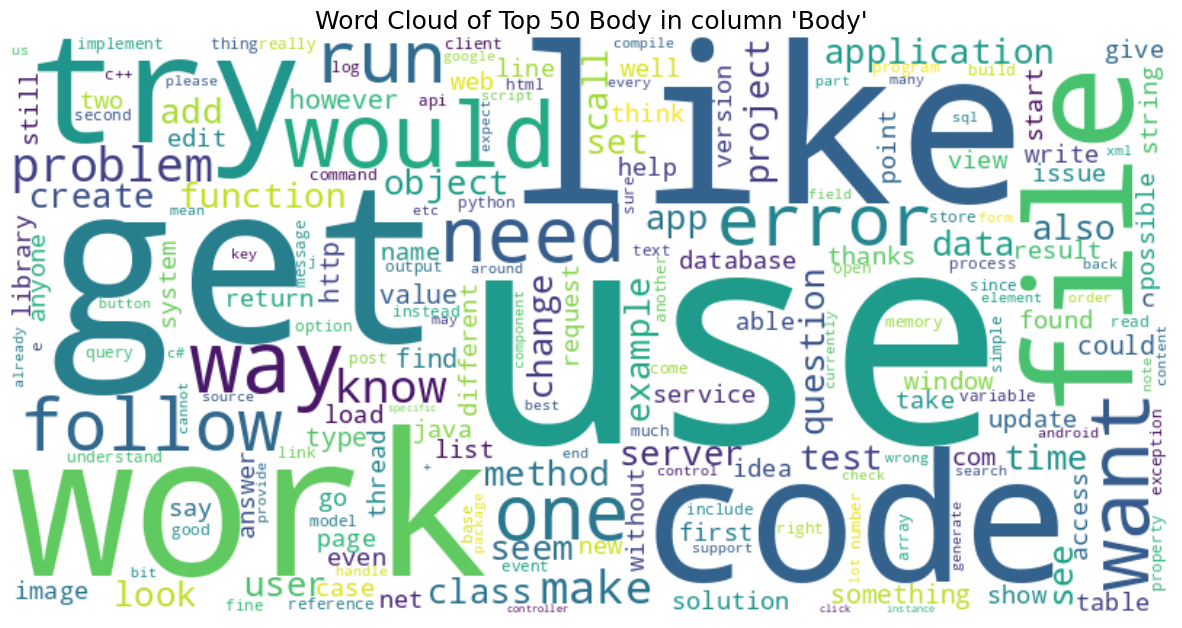

In [ ]:
plot_info(df, 'Body')

The dataset contains 5437 unique Title in column 'Title'.
The dataset contains 2915 unique Title used once only in column 'Title'.


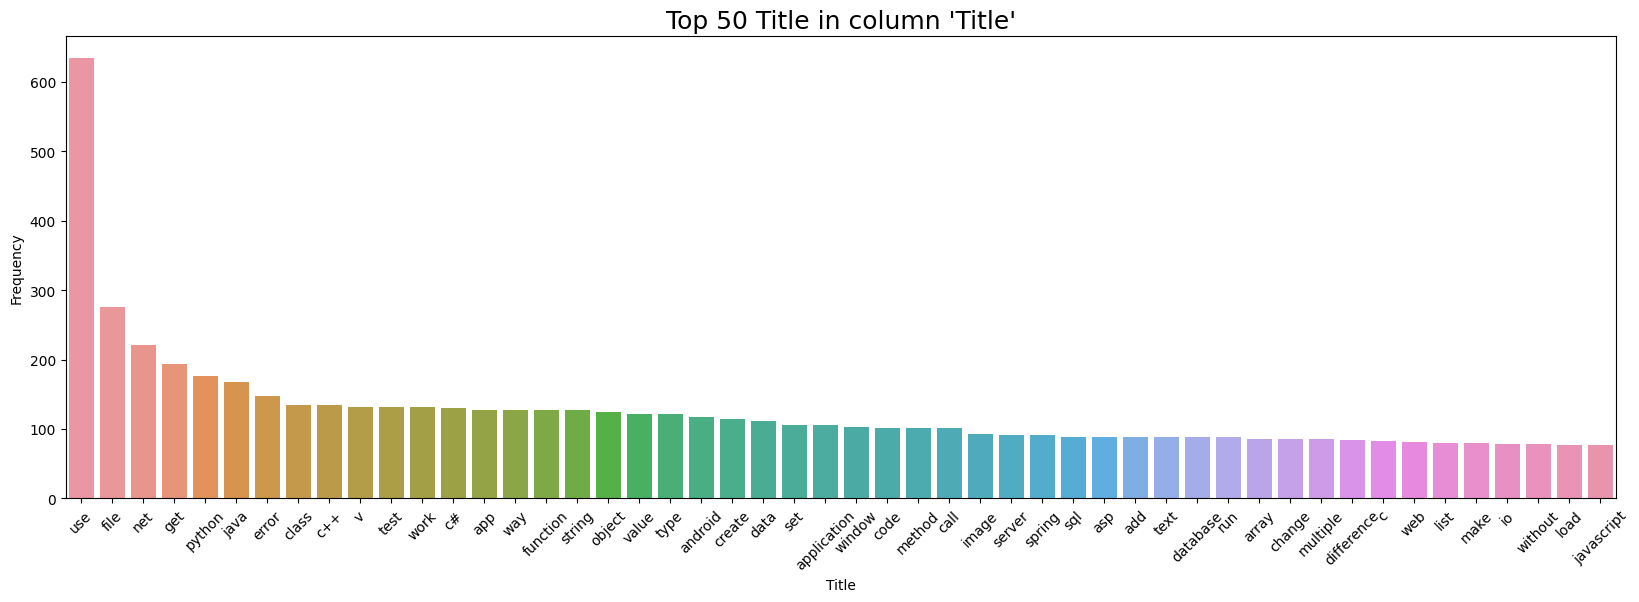

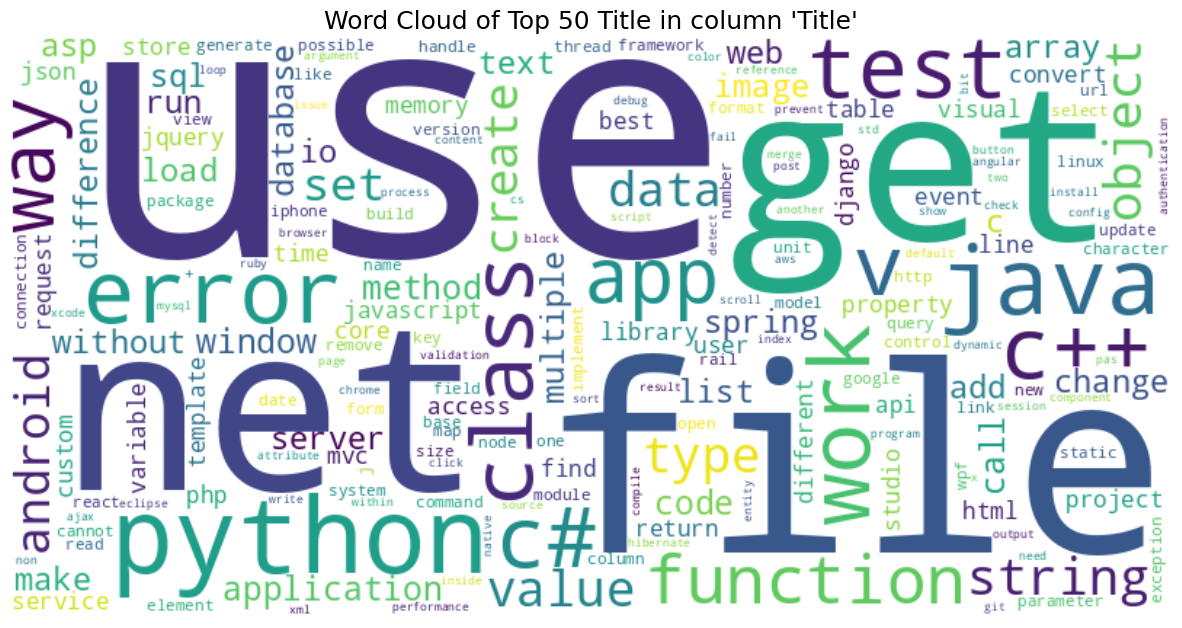

In [ ]:
plot_info(df, 'Title')

In [ ]:

def remove_single_occurrence_tags(dataframe, column):
    # Flatten the list of tags
    all_tags = dataframe[column].explode()

    # Count the occurrences of each tag
    tag_counts = all_tags.value_counts()

    # Get the tags that appear only once
    tags_to_remove = tag_counts[tag_counts == 1].index

    # Remove rows containing tags used only once
    filtered_dataframe = dataframe[~dataframe[column].apply(lambda x: any(tag in tags_to_remove for tag in x))]

    return filtered_dataframe


In [ ]:
filtered_df = remove_single_occurrence_tags(df, 'Tags')

In [ ]:
filtered_df

,Tags,Body,Title
0,"[php, laravel, laravel, laravel, request, lara...","[want, run, form, submit, however, return, arr...","[exclude, laravel, specific, value, request]"
1,"[java, private, public, protect, access, modif...","[java, clear, rule, use, access, modifier, nam...","[difference, public, protect, package, private..."
2,"[python, numpy, machine, learn, scipy, scikit,...","[try, principal, component, analysis, datasets...","[principal, component, analysis, work]"
3,"[c#, net, m, word, docx, doc]","[load, m, word, document, doc, docx, memory, v...","[load, text, m, word, document, c#, net]"
6,"[visual, studio, visual, studio, visual, c++, ...","[hard, would, use, gcc, instead, vc++, within,...","[gcc, visual, studio]"
...,...,...,...
4995,"[git, github, export, wiki, gitlab]","[currently, work, github, actually, quiet, hap...","[migrate, export, github, wiki, gitlab]"
4996,"[python, delphi, embed, c++builder, c++builder]","[interested, experiment, embed, python, applic...","[embed, python, c++, builder, delphi, applicat..."
4997,"[git, bitbucket, git, branch, pull, request, g...","[environment, local, git, connect, bitbucket, ...","[delete, local, branch, merge, pull, request, ..."
4998,"[c#, unit, test, mock, moq, mstest]","[currently, use, moq, help, unit, test, howeve...","[unit, test, throwifcancellationrequested, call]"


In [ ]:
df = filtered_df
df.to_csv('/content/drive/MyDrive/df_cleaned.csv', index=False)